# MNIST Handwritten Image Dataset

* The MNIST data set consists of 70,000 images of handwritten digits. It consists of digits from 0 to 9, and we are required to classify the class to which the image belongs. The images in the MNIST data set are 28X28 pixels, and the input layer has 784 neurons (each neuron takes 1 pixel as the input). The output layer has 10 neurons, with each giving the probability of the input image belonging to any of the 10 classes.

In [1]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Dealing packages 
import pickle # data serialization library
import gzip # compression library
from PIL import Image
from scipy import ndimage

# decorator packages
from sklearn.base import (TransformerMixin, 
                          BaseEstimator)
from typing import Dict, List

Some new libraries:
1. pickle : Python Object serialisation library which converts python object into byte streams and vice versa
2. gzip : Used to compress and decompress files with .gz extension
3. h5py : This allows us to store and manipulate large numerical datasets.


In [50]:
os.getcwd()

'/Users/kavisanthoshkumar/Library/CloudStorage/OneDrive-IllinoisInstituteofTechnology/MachineLearning_CodingStuff/deep_learning_sans/Neural_Networks/FeedForward_NN'

# Load MNIST Dataset
* The MNIST dataset which is divided into training, validation and test dataset
* The User-defined function helps us to unpack the file and extracts the training, validation and test 

In [2]:
def load_data():
    # Open gz file which is serialized object
    f = gzip.open('/Users/kavisanthoshkumar/Library/CloudStorage/OneDrive-IllinoisInstituteofTechnology/MachineLearning_CodingStuff/mnist.pkl.gz', 'rb')
    f.seek(0)

    # Using pickle we deserialized the object
    training_data, validation_data, test_data = pickle.load(
        f,
        encoding = 'latin1'
    )

    # Close the file
    f.close()

    return training_data, validation_data, test_data


training_data, validation_data, test_data = load_data()

In [3]:
# feature and target dataset
print(f"Shape of the training feature dataset: {training_data[0].shape}")
#print(f" The feature dataset is: \n {training_data[0]}")

print(f"\n\nShape of the training label dataset: {training_data[1].shape}")
#print(f"The label dataset is: \n {training_data[1][1]}")
print(f"Length of Unique Classes: {len(np.unique(training_data[1]))}")

# Number of datapoints in each input 
print(f"\nThe number of points in a single input is: {len(training_data[0][1])}")

Shape of the training feature dataset: (50000, 784)


Shape of the training label dataset: (50000,)
Length of Unique Classes: 10

The number of points in a single input is: 784


# Step 1: Data Preparation

### 1.Splitting the Wrapped dataset into feature and labels

In [4]:
# Unwrap Training dataset
X_train = training_data[0]
y_train = training_data[1]

# Unwrap Validation dataset
X_valid = validation_data[0]
y_valid = validation_data[1]

# Unwrap test dataset
X_test = test_data[0]
y_test = test_data[1]


### 2. Perform One-Hot Encoding on label dataset

In [5]:
def one_hot_encoding(label_array: np.array) -> np.array:

    # Create a zero matrix of shape = (length of label matrix, max label)
    zero_arr = np.zeros((label_array.shape[0],
              label_array.max() + 1))    
    
    # Update the zero_array 
    zero_arr[np.arange(zero_arr.shape[0]), label_array] = 1.0

    return zero_arr


y_train_encoded = one_hot_encoding(y_train)
y_valid_encoded = one_hot_encoding(y_valid)
y_test_encoded = one_hot_encoding(y_test)

In [6]:
print(f"training set(X_train) shape: {X_train.shape}")
print(f"training set(y_train) shape: {y_train.shape}")

print(f"\nValidation set(X_valid) shape: {X_valid.shape}")
print(f"Validation set(y_valid) shape: {y_valid.shape}")

print(f"\ntest set(X_test) shape: {X_test.shape}")
print(f"test set(y_test) shape: {y_test.shape}")

training set(X_train) shape: (50000, 784)
training set(y_train) shape: (50000,)

Validation set(X_valid) shape: (10000, 784)
Validation set(y_valid) shape: (10000,)

test set(X_test) shape: (10000, 784)
test set(y_test) shape: (10000,)


### 3. Visualise a sample Image from the training set:

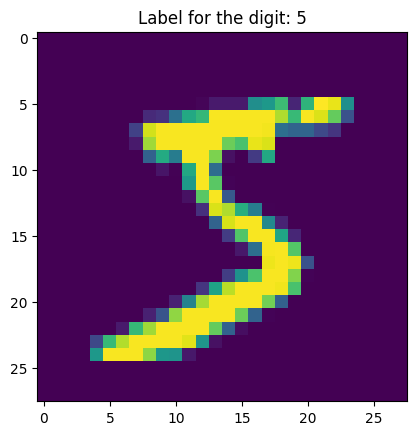

In [7]:
label = training_data[1][0]
sample_img = X_train[0].reshape((28, 28))

# plt to visualise the image
plt.imshow(sample_img)
plt.title(f"Label for the digit: {label}")
plt.show()

# Step 2: Feed Forward Neural Network Approach

## Step 2.1: Activation Function

*  Sigmoid AF

    * This is one of the activation function, It takes the cummulative input to the layer, the matrix Z, as the input 

                        sigmoid f(x) = 1/(1 + exp(-z))

*  ReLU AF
    *  if Output = x for x >= 0
    *  if Output = 0 otherwise

    * 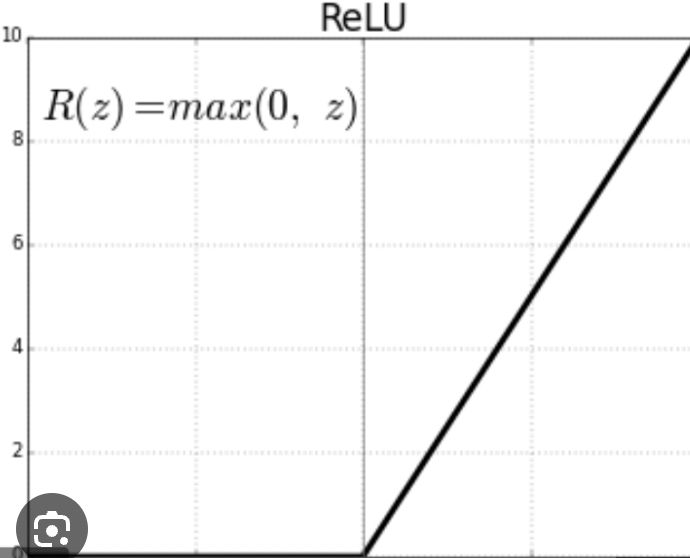


* Softmax Activation Function 

    * 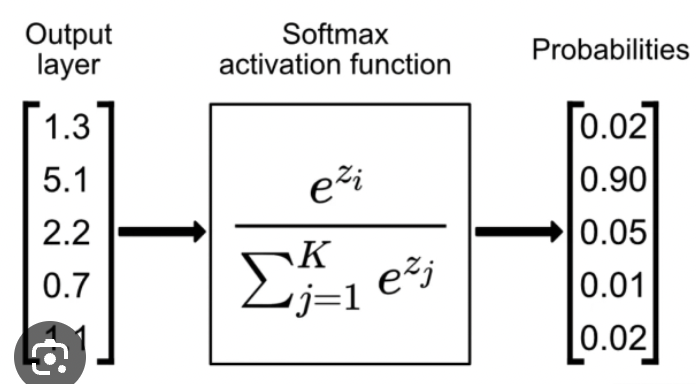

In [8]:
# sigmoid
def sigmoid(Z):
    H = 1/(1 + np.exp(-Z))
    # sigmoid memory is stored as it is used later on in backpropagation
    sigmoid_memory = Z

    return H, sigmoid_memory


# relu
def relu(Z):
    H = np.maximum(0, Z)

    # Make sure the shape of the H is same as Z
    assert(H.shape == Z.shape)

    # relu memory is stored as it is used later on in backpropagation
    relu_memory = Z

    return H, relu_memory


# softmax AF
def softmax(Z):
    # numerator component
    Z_exp = np.exp(Z)

    # denominator component
    Z_sum = np.sum(Z_exp, axis = 0, keepdims=True)

    H = Z_exp/Z_sum

    softmax_memory = Z

    return H, softmax_memory 

## Step 2.2: Initializing Parameters

In [9]:
def initialize_parameters(dimensions):

    np.random.seed(2)
    
    parameters = {} # Declare empty dictionary
    L = len(dimensions)

    for l in range(1, L):
        
        parameters["W"+str(l)] = np.random.randn(dimensions[l], dimensions[l-1])*0.1
        parameters["b"+str(l)] = np.zeros((dimensions[l], 1))

        assert(parameters["W"+str(l)].shape == (dimensions[l], dimensions[l-1]))
        assert(parameters["b"+str(l)].shape == (dimensions[l], 1))

    
    return parameters


In [10]:
initialize_parameters(dimensions = [784, 3, 4, 10])

{'W1': array([[-0.04167578, -0.00562668, -0.21361961, ..., -0.06168445,
          0.03213358, -0.09464469],
        [-0.05301394, -0.1259207 ,  0.16775441, ..., -0.03284246,
         -0.05623108,  0.01179136],
        [ 0.07386378, -0.15872956,  0.01532001, ..., -0.08428557,
          0.10040469,  0.00545832]]),
 'b1': array([[0.],
        [0.],
        [0.]]),
 'W2': array([[ 0.06650944, -0.19626047,  0.2112715 ],
        [-0.28074571, -0.13967752,  0.02641189],
        [ 0.10925169,  0.06646016,  0.08565535],
        [-0.11058228,  0.03715795,  0.13440124]]),
 'b2': array([[0.],
        [0.],
        [0.],
        [0.]]),
 'W3': array([[-0.16421272, -0.1153127 ,  0.02013163,  0.13985659],
        [ 0.07228733, -0.10717236, -0.05673344, -0.03663499],
        [-0.15460347,  0.20406947, -0.04960206, -0.06131668],
        [-0.17449682,  0.01840741, -0.00795452,  0.12406296],
        [ 0.08625738, -0.01239074,  0.05854764,  0.19336815],
        [-0.07322525, -0.039205  ,  0.07512152, -0.0

## Step 2: Layered Forward

In [11]:
def layer_forward(H_prev, 
                  W, 
                  b, 
                  activation = 'relu') -> tuple[np.array, np.array]:
    
    if activation == 'sigmoid':
        Z = np.dot(W, H_prev) + b
        linear_memory = (H_prev, W, b)
        H, activation_memory = sigmoid(Z)

    elif activation == "relu":
        Z = np.dot(W, H_prev) + b
        linear_memory = (H_prev, W, b)
        H, activation_memory = relu(Z)

    # We use at the last layer to normalize the values
    elif activation == "softmax":
        Z = np.dot(W, H_prev) + b
        linear_memory = (H_prev, W, b)
        H, activation_memory = softmax(Z)


    assert(H.shape == (W.shape[0], H_prev.shape[1]))
    memory = (linear_memory, activation_memory)

    return H, memory


## Step 3: Forward Propagation

In [19]:
def forward_prog(X, parameters):

    memories = []
    H = X
    L = len(parameters) // 2

    for l in range(1, L):
        H_prev = H

        # Calculating H value for the next layer
        H, memory = layer_forward(H_prev,
                                  parameters["W"+str(l)],
                                  parameters["b"+str(l)],
                                  activation = 'relu')
        
        memories.append(memory)


    HL, memory = layer_forward(H,
                               parameters["W"+str(L)],
                               parameters["b"+str(L)],
                               activation = "softmax")
    
    memories.append(memory)
    print(HL.shape)

    assert(HL.shape == (10, X.shape[1]))

    return HL, memory

## Step 4: Performing Feed Forward Neural Networks

In [18]:
# Declare Dimensions
dimensions = [784, 3, 4, 10]
#[no.of features, 
# no.of nodes at first hidden layer, 
# no.of nodes at second hidden layer, 
# no.of nodes at output layer]

# Initializing Parameters
parameters = initialize_parameters(dimensions = [784, 3, 4, 10])

# Print the resultant weights and biases
print("W1 = " + str(parameters["W1"].shape))
print("b1 = " + str(parameters["b1"].shape))
print("W2 = " + str(parameters["W2"].shape))
print("b2 = " + str(parameters["b2"].shape))
print("W3 = " + str(parameters["W3"].shape))
print("b3 = " + str(parameters["b3"].shape))


W1 = (3, 784)
b1 = (3, 1)
W2 = (4, 3)
b2 = (4, 1)
W3 = (10, 4)
b3 = (10, 1)


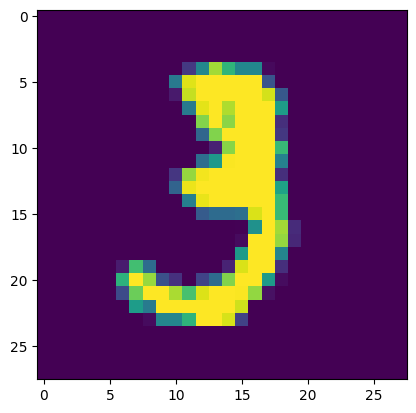

In [79]:
plt.imshow(X_train[10:20, :].reshape((10, 28, 28))[0])

In [21]:
HL, memory = forward_prog(X_train[:, :].T, parameters=parameters)

(10, 50000)


In [25]:
HL

array([[0.09868003, 0.09823838, 0.09928614, ..., 0.09882627, 0.09966891,
        0.1       ],
       [0.10043691, 0.10058143, 0.10026627, ..., 0.10042849, 0.09936809,
        0.1       ],
       [0.09521314, 0.09429107, 0.09818599, ..., 0.09703981, 0.09333899,
        0.1       ],
       ...,
       [0.09900203, 0.09871299, 0.09952678, ..., 0.09921872, 0.09895624,
        0.1       ],
       [0.09877596, 0.09850877, 0.09952696, ..., 0.09921901, 0.09877347,
        0.1       ],
       [0.10181951, 0.10235816, 0.10093395, ..., 0.10152568, 0.10067107,
        0.1       ]])